# Installation

In [ ]:
!pip3 install openmim
!mim install mmcv-full

In [ ]:
!git clone https://github.com/open-mmlab/mmaction2.git
%cd mmaction2

!pip install -e .

# Install some optional requirements
!pip install -r requirements/optional.txt

In [ ]:
%cd /content
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

In [ ]:
%cd /content
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose

# install mmpose dependencies
#%pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

In [ ]:
%cd /content

In [ ]:
!pip install seaborn

In [ ]:
!apt-get install poppler-utils

In [ ]:
!pip install pdf2image

## Check

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmpose installation
import mmpose
print(mmpose.__version__)

# Check mmdet installation
import mmdet
print(mmdet.__version__)

1.13.0+cu116 True
0.24.1
11.6
GCC 9.3
0.29.0
2.27.0


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


# Dataset

Manually mount google drive

## Analysis (stats)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

%cd /content/drive/MyDrive/Martial_Arts/data1

train_df = pd.read_csv('data1_train.txt', sep = ' ', header=None, names = ['clip', 'class'])
val_df = pd.read_csv('data1_val.txt', sep = ' ', header=None, names = ['clip', 'class'])
test_df = pd.read_csv('data1_test.txt', sep = ' ', header=None, names = ['clip', 'class'])

full_df = pd.concat([train_df, val_df, test_df])
full_df.sample(frac=1).reset_index(drop=True)

train_df['class'] = train_df['class'].astype(int)
val_df['class'] = val_df['class'].astype(int)
test_df['class'] = test_df['class'].astype(int)
full_df['class'] = full_df['class'].astype(int)


/content/drive/MyDrive/Martial_Arts/data1


In [ ]:
full_df.head()

clip  class
0  ceUPJjMYBW8_1.mp4      0
1  IRbX2K3GAPg_2.mp4      0
2  _tMrLgMEP2s_2.mp4      0
3  KHqKhbn16GI_6.mp4      2
4  NSEvrU18eww_4.mp4      1

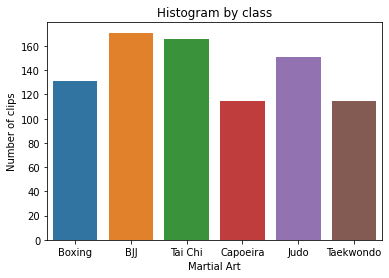

class
0    0.154299
1    0.201413
2    0.195524
3    0.135453
4    0.177856
5    0.135453
dtype: float64

In [ ]:
fig = sns.countplot(x = full_df['class'], label="Count")
fig.set(xlabel='Martial Art', ylabel='Number of clips', title = "Histogram by class", xticklabels = ['Boxing', 'BJJ', 'Tai Chi', 'Capoeira', 'Judo', 'Taekwondo'])
plt.savefig('histogram_full_data1.png')
plt.show()

full_df.groupby('class').size()/849

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (16,5))
fig.suptitle('Histogram plots')
sns.countplot(train_df['class'], label="Count", ax = axes[0])
axes[0].set_title('train hist')
sns.countplot(val_df['class'], label="Count", ax = axes[1])
axes[1].set_title('val hist')
sns.countplot(test_df['class'], label="Count", ax = axes[2])
axes[2].set_title('test hist')
#sns.countplot(full_df['class'], label="Count", ax = axes[3])
#axes[3].set_title('full hist')

#train_df.hist(by = 'class', bins=3)
#plt.hist(train_df.loc[:, 'class'])

# **RGB action recognition**

## Timesformer finetuning

In [ ]:
%cd /content/mmaction2

/content/mmaction2


### Config

**Download checkpoint for RGB pre-trained model:**


In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/timesformer/timesformer_divST_8x32x1_15e_kinetics400_rgb/timesformer_divST_8x32x1_15e_kinetics400_rgb-3f8e5d03.pth \
      -O checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth

--2023-01-17 11:47:18--  https://download.openmmlab.com/mmaction/recognition/timesformer/timesformer_divST_8x32x1_15e_kinetics400_rgb/timesformer_divST_8x32x1_15e_kinetics400_rgb-3f8e5d03.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.204, 47.246.48.209, 47.246.48.211, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486364592 (464M) [application/octet-stream]
Saving to: ‘checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth’

checkpoints/timesfo 100%[===================>] 463.83M  29.2MB/s    in 17s     

2023-01-17 11:47:36 (26.6 MB/s) - ‘checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth’ saved [486364592/486364592]



**Load (download?) config from pre-trained model, and edit for current model:**


In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/timesformer/timesformer_divST_8x32x1_15e_kinetics400_rgb.py')

In [ ]:
data_path = '../drive/MyDrive/Martial_Arts/'

In [ ]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = data_path + 'data1/train/'
cfg.data_root_val = data_path + 'data1/val/'
cfg.ann_file_train = data_path + 'data1/data1_train.txt'
cfg.ann_file_val = data_path + 'data1/data1_val.txt'
cfg.ann_file_test = data_path + 'data1/data1_test.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = data_path + 'data1/data1_test.txt'
cfg.data.test.data_prefix = data_path + 'data1/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = data_path + 'data1/data1_train.txt'
cfg.data.train.data_prefix = data_path + 'data1/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = data_path + 'data1/data1_val.txt'
cfg.data.val.data_prefix = data_path + 'data1/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# Add extra options in cls_head
cfg.model.cls_head.topk = (1, 2, 3, 4, 5)
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth'

# Set up working dir to save files and logs.
cfg.work_dir = data_path + 'models/Timesformer'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 2 
cfg.optimizer.lr = cfg.optimizer.lr /2
cfg.total_epochs = 10

cfg.data.workers_per_gpu = 2

# Data pipelines
img_norm_cfg = dict(mean=[127.5, 127.5, 127.5],
                    std=[127.5, 127.5, 127.5],
                    to_bgr=False)
cfg.train_pipeline = [
    dict(type='DecordInit'),
    # * frame_interval has been selected for 7s clips
    dict(type='SampleFrames', clip_len=16, frame_interval=12, num_clips=1),
    dict(type='DecordDecode'),
    dict(type='RandomRescale', scale_range=(256, 320)),
    dict(type='RandomCrop', size=224),
    dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.val_pipeline = [
    dict(type='DecordInit'),
    dict(type='SampleFrames',
         clip_len=16,
         frame_interval=12,
         num_clips=1,
         test_mode=True),
    dict(type='DecordDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.test_pipeline = [
    dict(type='DecordInit'),
    dict(type='SampleFrames',
         clip_len=16,
         frame_interval=12,
         num_clips=1,
         test_mode=True),
    dict(type='DecordDecode'),
    dict(type='Resize', scale=(-1, 224)),
    dict(type='ThreeCrop', crop_size=224),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline


cfg.model.backbone.num_frames = 16

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 5
# We can set the log print interval to reduce the the times of printing log
#cfg.log_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 1
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Save the best
cfg.evaluation.save_best='auto'

#Change evaluation metrics (for validation and then testing)
cfg.evaluation.topk = (1, 2, 3, 4, 5)

## If want to check loss on validation set as well:
#cfg.workflow = [('train', 1), ('val', 1)]
#cfg.data.val_dataloader = dict(videos_per_gpu=1)



# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=5)
log_config = dict(interval=20, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='TimeSformer',
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/timesformer/vit_base_patch16_224.pth',
        num_frames=16,
        img_size=224,
        patch_size=16,
        embed_dims=768,
        in_channels=3,
        dropout_ratio=0.0,
        transformer_layers=None,
        attention_type='divided_space_time',
        norm_cfg=dict(type='LN', eps=1e-06)),
    cls_head=dict(
        type='TimeSformerHead',
        num_classes=6,
        in_channels=768,
        topk=(1, 2, 3, 4, 5)),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))


### Train

**Build model:**

In [ ]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

2023-01-17 11:47:50,965 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/timesformer/vit_base_patch16_224.pth
Downloading: "https://download.openmmlab.com/mmaction/recognition/timesformer/vit_base_patch16_224.pth" to /root/.cache/torch/hub/checkpoints/vit_base_patch16_224.pth


load checkpoint from http path: https://download.openmmlab.com/mmaction/recognition/timesformer/vit_base_patch16_224.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

2023-01-17 11:48:16,976 - mmaction - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: time_embed, transformer_layers.layers.0.attentions.0.temporal_fc.weight, transformer_layers.layers.0.attentions.0.temporal_fc.bias, transformer_layers.layers.1.attentions.0.temporal_fc.weight, transformer_layers.layers.1.attentions.0.temporal_fc.bias, transformer_layers.layers.2.attentions.0.temporal_fc.weight, transformer_layers.layers.2.attentions.0.temporal_fc.bias, transformer_layers.layers.3.attentions.0.temporal_fc.weight, transformer_layers.layers.3.attentions.0.temporal_fc.bias, transformer_layers.layers.4.attentions.0.temporal_fc.weight, transformer_layers.layers.4.attentions.0.temporal_fc.bias, transformer_layers.layers.5.attentions.0.temporal_fc.weight, transformer_layers.layers.5.attentions.0.temporal_fc.bias, transformer_layers.layers.6.attentions.0.temporal_fc.weight, transformer_layers.layers.6.attentions.0.temporal_fc.bias, transformer_

Train model (and save resulting variable in case of runtime disconnect):

In [ ]:
import pickle

train_model(model, datasets, cfg, distributed=False, validate=True)

# save trained model as a variable in case of runtime shutdown
with open(data_path + 'models/Timesformer/backup_model.pkl', 'wb') as file:
    pickle.dump(model, file)

2023-01-17 11:48:21,956 - mmaction - INFO - load checkpoint from local path: ./checkpoints/timesformer_divST_8x32x1_15e_kinetics400_rgb.pth
2023-01-17 11:48:22,264 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for backbone.time_embed: copying a param with shape torch.Size([1, 8, 768]) from checkpoint, the shape in current model is torch.Size([1, 16, 768]).
size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 768]) from checkpoint, the shape in current model is torch.Size([6, 768]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2023-01-17 11:48:22,272 - mmaction - INFO - Start running, host: root@3446f8897af6, work_dir: /content/drive/MyDrive/Martial_Arts/models/Timesformer
2023-01-17 11:48:22,273 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.1 task/s, elapsed: 118s, ETA:     0s

/content/mmaction2/mmaction/datasets/base.py:166: UserWarning: Option arguments for metrics has been changed to `metric_options`, See 'https://github.com/open-mmlab/mmaction2/pull/286' for more details
  warnings.warn(
2023-01-17 12:01:06,816 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:01:06,821 - mmaction - INFO - 
top1_acc	0.9528
top2_acc	0.9764
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:01:06,823 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:01:06,827 - mmaction - INFO - 
mean_acc	0.9452
2023-01-17 12:01:13,815 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_1.pth.
2023-01-17 12:01:13,817 - mmaction - INFO - Best top1_acc is 0.9528 at 1 epoch.
2023-01-17 12:01:13,821 - mmaction - INFO - Epoch(val) [1][64]	top1_acc: 0.9528, top2_acc: 0.9764, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9452
2023-01-17 12:01:56,522 - mmaction - INFO - Epoch [2][20/297]	lr: 2.500e-03, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 105s, ETA:     0s

2023-01-17 12:12:07,741 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:12:07,745 - mmaction - INFO - 
top1_acc	0.9055
top2_acc	0.9764
top3_acc	0.9921
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:12:07,747 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:12:07,750 - mmaction - INFO - 
mean_acc	0.9017
2023-01-17 12:12:07,753 - mmaction - INFO - Epoch(val) [2][64]	top1_acc: 0.9055, top2_acc: 0.9764, top3_acc: 0.9921, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9017
2023-01-17 12:12:52,227 - mmaction - INFO - Epoch [3][20/297]	lr: 2.500e-03, eta: 1:14:59, time: 2.223, data_time: 0.545, memory: 7632, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0302, loss: 0.0302, grad_norm: 1.4643
2023-01-17 12:13:28,166 - mmaction - INFO - Epoch [3][40/297]	lr: 2.500e-03, eta: 1:14:13, time: 1.797, data_time: 0.175, memory: 7632, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.00

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 108s, ETA:     0s

2023-01-17 12:23:00,227 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:23:00,230 - mmaction - INFO - 
top1_acc	0.9213
top2_acc	0.9843
top3_acc	0.9921
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:23:00,232 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:23:00,235 - mmaction - INFO - 
mean_acc	0.9227
2023-01-17 12:23:00,238 - mmaction - INFO - Epoch(val) [3][64]	top1_acc: 0.9213, top2_acc: 0.9843, top3_acc: 0.9921, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9227
2023-01-17 12:23:40,355 - mmaction - INFO - Epoch [4][20/297]	lr: 2.500e-03, eta: 1:03:21, time: 2.005, data_time: 0.302, memory: 7632, top1_acc: 0.9750, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0655, loss: 0.0655, grad_norm: 2.7855
2023-01-17 12:24:18,841 - mmaction - INFO - Epoch [4][40/297]	lr: 2.500e-03, eta: 1:02:48, time: 1.924, data_time: 0.315, memory: 7632, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.00

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 108s, ETA:     0s

2023-01-17 12:33:47,456 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:33:47,461 - mmaction - INFO - 
top1_acc	0.8976
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:33:47,462 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:33:47,468 - mmaction - INFO - 
mean_acc	0.8703
2023-01-17 12:33:47,470 - mmaction - INFO - Epoch(val) [4][64]	top1_acc: 0.8976, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.8703
2023-01-17 12:34:30,897 - mmaction - INFO - Epoch [5][20/297]	lr: 2.500e-03, eta: 0:53:22, time: 2.171, data_time: 0.485, memory: 7632, top1_acc: 0.9500, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.2445, loss: 0.2445, grad_norm: 4.2071
2023-01-17 12:35:05,243 - mmaction - INFO - Epoch [5][40/297]	lr: 2.500e-03, eta: 0:52:42, time: 1.717, data_time: 0.097, memory: 7632, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.00

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.1 task/s, elapsed: 111s, ETA:     0s

2023-01-17 12:44:48,200 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:44:48,208 - mmaction - INFO - 
top1_acc	0.9606
top2_acc	0.9921
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:44:48,211 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:44:48,214 - mmaction - INFO - 
mean_acc	0.9599
2023-01-17 12:44:48,222 - mmaction - INFO - The previous best checkpoint /content/drive/MyDrive/Martial_Arts/models/Timesformer/best_top1_acc_epoch_1.pth was removed
2023-01-17 12:44:54,803 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2023-01-17 12:44:54,805 - mmaction - INFO - Best top1_acc is 0.9606 at 5 epoch.
2023-01-17 12:44:54,808 - mmaction - INFO - Epoch(val) [5][64]	top1_acc: 0.9606, top2_acc: 0.9921, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9599
2023-01-17 12:45:37,854 - mmaction - INFO - Epoch [6][20/297]	lr: 2.500e-04, eta: 0:43:55, time: 2.152, data_time: 0.450, memory: 7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 109s, ETA:     0s

2023-01-17 12:55:47,466 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 12:55:47,468 - mmaction - INFO - 
top1_acc	0.9764
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 12:55:47,471 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 12:55:47,475 - mmaction - INFO - 
mean_acc	0.9780
2023-01-17 12:55:47,484 - mmaction - INFO - The previous best checkpoint /content/drive/MyDrive/Martial_Arts/models/Timesformer/best_top1_acc_epoch_5.pth was removed
2023-01-17 12:55:53,885 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_6.pth.
2023-01-17 12:55:53,886 - mmaction - INFO - Best top1_acc is 0.9764 at 6 epoch.
2023-01-17 12:55:53,890 - mmaction - INFO - Epoch(val) [6][64]	top1_acc: 0.9764, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9780
2023-01-17 12:56:36,475 - mmaction - INFO - Epoch [7][20/297]	lr: 2.500e-04, eta: 0:34:48, time: 2.128, data_time: 0.440, memory: 7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 109s, ETA:     0s

2023-01-17 13:06:48,122 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 13:06:48,125 - mmaction - INFO - 
top1_acc	0.9764
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 13:06:48,128 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 13:06:48,131 - mmaction - INFO - 
mean_acc	0.9780
2023-01-17 13:06:48,137 - mmaction - INFO - Epoch(val) [7][64]	top1_acc: 0.9764, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9780
2023-01-17 13:07:31,674 - mmaction - INFO - Epoch [8][20/297]	lr: 2.500e-04, eta: 0:25:51, time: 2.176, data_time: 0.504, memory: 7706, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0014, loss: 0.0014, grad_norm: 0.0888
2023-01-17 13:08:09,309 - mmaction - INFO - Epoch [8][40/297]	lr: 2.500e-04, eta: 0:25:16, time: 1.882, data_time: 0.258, memory: 7706, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.00

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 109s, ETA:     0s

2023-01-17 13:17:39,775 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 13:17:39,777 - mmaction - INFO - 
top1_acc	0.9843
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 13:17:39,780 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 13:17:39,783 - mmaction - INFO - 
mean_acc	0.9863
2023-01-17 13:17:39,792 - mmaction - INFO - The previous best checkpoint /content/drive/MyDrive/Martial_Arts/models/Timesformer/best_top1_acc_epoch_6.pth was removed
2023-01-17 13:17:46,119 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_8.pth.
2023-01-17 13:17:46,121 - mmaction - INFO - Best top1_acc is 0.9843 at 8 epoch.
2023-01-17 13:17:46,123 - mmaction - INFO - Epoch(val) [8][64]	top1_acc: 0.9843, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9863
2023-01-17 13:18:29,766 - mmaction - INFO - Epoch [9][20/297]	lr: 2.500e-04, eta: 0:16:58, time: 2.181, data_time: 0.485, memory: 7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 105s, ETA:     0s

2023-01-17 13:28:38,170 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 13:28:38,172 - mmaction - INFO - 
top1_acc	0.9764
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 13:28:38,177 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 13:28:38,179 - mmaction - INFO - 
mean_acc	0.9735
2023-01-17 13:28:38,181 - mmaction - INFO - Epoch(val) [9][64]	top1_acc: 0.9764, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9735
2023-01-17 13:29:23,988 - mmaction - INFO - Epoch [10][20/297]	lr: 2.500e-04, eta: 0:08:10, time: 2.289, data_time: 0.591, memory: 7706, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0102, loss: 0.0102, grad_norm: 0.3882
2023-01-17 13:30:02,227 - mmaction - INFO - Epoch [10][40/297]	lr: 2.500e-04, eta: 0:07:35, time: 1.912, data_time: 0.298, memory: 7706, top1_acc: 1.0000, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 1.2 task/s, elapsed: 109s, ETA:     0s

2023-01-17 13:39:43,182 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-17 13:39:43,185 - mmaction - INFO - 
top1_acc	0.9685
top2_acc	1.0000
top3_acc	1.0000
top4_acc	1.0000
top5_acc	1.0000
2023-01-17 13:39:43,188 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-17 13:39:43,191 - mmaction - INFO - 
mean_acc	0.9652
2023-01-17 13:39:43,193 - mmaction - INFO - Epoch(val) [10][64]	top1_acc: 0.9685, top2_acc: 1.0000, top3_acc: 1.0000, top4_acc: 1.0000, top5_acc: 1.0000, mean_class_accuracy: 0.9652


Only run if runtime disconnect:

In [ ]:
#del model
#%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import pickle

# in case of runtime shutdown, load model variable to avoid re-training (after manually running the pre-trained cells)
with open(data_path + 'models/Timesformer/backup_model.pkl', 'rb') as file:
    model = pickle.load(file)

### Test

Evaluate performance in test set:

In [ ]:
%cd /content/mmaction2

/content/mmaction2


In [ ]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)


eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 128/128, 0.8 task/s, elapsed: 153s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9688
top2_acc	0.9844
top3_acc	0.9844
top4_acc	0.9844
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9734
top1_acc: 0.9688
top2_acc: 0.9844
top3_acc: 0.9844
top4_acc: 0.9844
top5_acc: 1.0000
mean_class_accuracy: 0.9734


Confusion Matrix:

/content/mmaction2
[[17.  0.  0.  0.  0.  0.]
 [ 0. 21.  0.  0.  0.  0.]
 [ 0.  0. 27.  0.  0.  0.]
 [ 0.  0.  0. 18.  1.  0.]
 [ 0.  0.  0.  0. 25.  3.]
 [ 0.  0.  0.  0.  0. 16.]]
[[17.]
 [21.]
 [27.]
 [19.]
 [28.]
 [16.]]


[Text(0, 0, 'boxing'),
 Text(0, 0, 'bjj'),
 Text(0, 0, 'tai_chi'),
 Text(0, 0, 'capoeira'),
 Text(0, 0, 'judo'),
 Text(0, 0, 'taekwondo')]

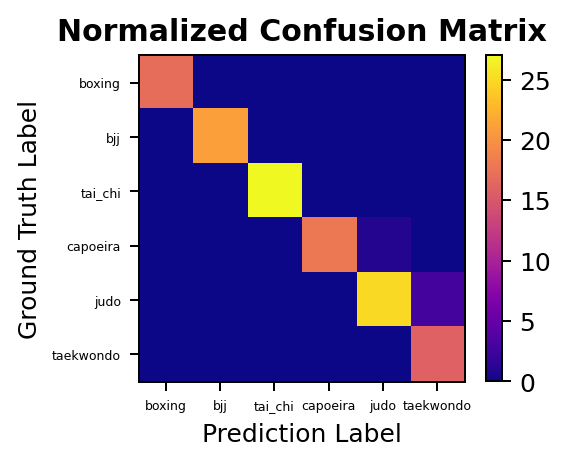

In [ ]:
%cd /content/mmaction2

from mmaction.core import (mean_class_accuracy, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt

gt_labels = list(test_df['class'])
#mean_class_accuracy(outputs, gt_labels)
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
print(cf_mat)


per_label_sums = cf_mat.sum(axis=1)[:, np.newaxis]
print(per_label_sums)
confusion_matrix = \
        cf_mat.astype(np.float32) / per_label_sums * 100

num_classes = 6
color_theme='plasma'
title='Normalized Confusion Matrix'
fig, ax = plt.subplots(
        figsize=(0.5 * num_classes, 0.5 * num_classes * 0.8), dpi=180)
cmap = plt.get_cmap(color_theme)
im = ax.imshow(cf_mat, cmap=cmap)
cbar = plt.colorbar(mappable=im, ax=ax)
#cbar.ax.locator_params(nbins=5)

title_font = {'weight': 'bold', 'size': 12}
ax.set_title(title, fontdict=title_font)
label_font = {'size': 10}
plt.ylabel('Ground Truth Label', fontdict=label_font)
plt.xlabel('Prediction Label', fontdict=label_font)


#ax.grid(True, which='minor', linestyle='-')

classes = ['boxing', 'bjj', 'tai_chi', 'capoeira', 'judo', 'taekwondo']
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes, size = 5)
ax.set_yticklabels(classes, size = 5)

Loss function visualized:

In [ ]:
!python tools/analysis/analyze_logs.py plot_curve ../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json --keys loss_cls --legend loss_cls --out ../drive/MyDrive/Martial_Arts/models/Timesformer/loss_graph.pdf

plot curve of ../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json, metric is loss_cls
save curve to: ../drive/MyDrive/Martial_Arts/models/Timesformer/loss_graph.pdf


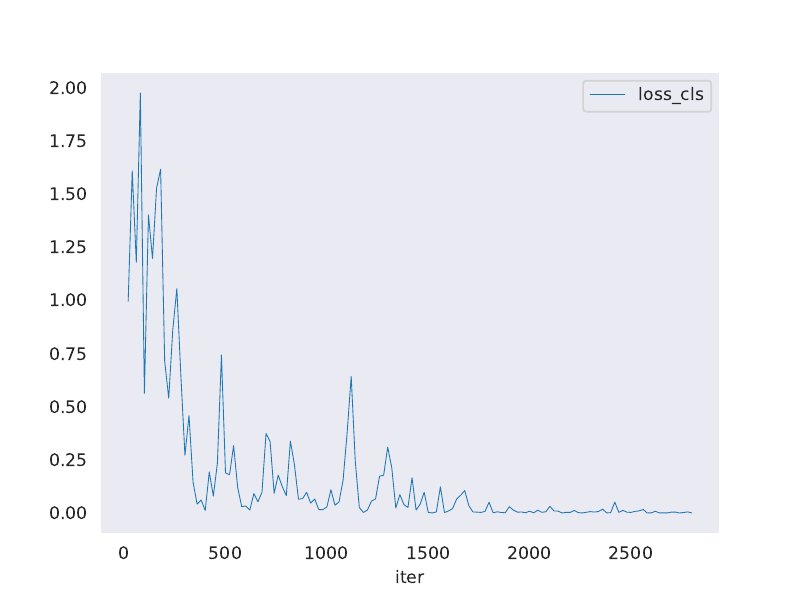

In [ ]:
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image

images = convert_from_bytes(open('../drive/MyDrive/Martial_Arts/models/Timesformer/loss_graph.pdf', 'rb').read(), size=800)
display(images[0])

Accuracy visualized:

In [ ]:
!python tools/analysis/analyze_logs.py plot_curve ../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json --keys top1_acc top2_acc --out ../drive/MyDrive/Martial_Arts/models/Timesformer/1vs2_graph.pdf

plot curve of ../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json, metric is top1_acc
plot curve of ../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json, metric is top2_acc
save curve to: ../drive/MyDrive/Martial_Arts/models/Timesformer/1vs2_graph.pdf


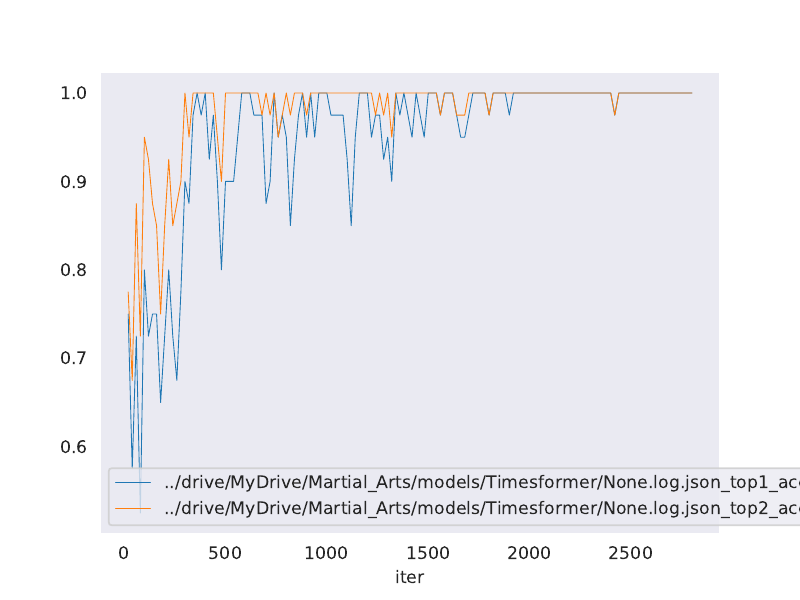

In [ ]:
images = convert_from_bytes(open('../drive/MyDrive/Martial_Arts/models/Timesformer/1vs2_graph.pdf', 'rb').read(), size=800)
display(images[0])

Manually read json file:

In [ ]:
import json

#necessary because log.json stores multiple dicts in parallel, for a json we need a big dicts of dicts
new_log = []
for line in open('../drive/MyDrive/Martial_Arts/models/Timesformer/None.log.json', 'r'):
    new_log.append(json.loads(line))

print(new_log)

## TSN finetuning - removed

In [ ]:
%cd /content/mmaction2

/content/mmaction2


# **Skeleton Action Recognition**

## PoseC3D finetuning

### Prepare annotations

In [ ]:
%cd /content

/content


Creating individual .pkl files for test dataset: 

In [ ]:
import subprocess as sp
import os

pose_extraction_path = 'drive/MyDrive/Martial_Arts/pose_extraction2.py'
test_data_path = 'drive/MyDrive/Martial_Arts/data1/test'
test_pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/test'

for vid in os.listdir(test_data_path):
  vid_pkl = vid.split('.')[0] + '.pkl'
  if vid_pkl not in os.listdir(test_pickle_path):
    command = 'python {} {} {}'.format(pose_extraction_path, test_data_path + '/' + vid, test_pickle_path + '/' + vid.split('.')[0] + '.pkl')
    result = sp.run(command, stdout=sp.PIPE, stderr=sp.PIPE, shell = True, text=True)
    print(result.returncode, result.stdout, result.stderr)

Creating individual .pkl files for val dataset: 

In [ ]:
import subprocess as sp
import os

pose_extraction_path = 'drive/MyDrive/Martial_Arts/pose_extraction2.py'
val_data_path = 'drive/MyDrive/Martial_Arts/data1/val'
val_pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/val'

count = 0

for vid in os.listdir(val_data_path):
  vid_pkl = vid.split('.')[0] + '.pkl'
  if vid_pkl not in os.listdir(val_pickle_path):
    command = 'python {} {} {}'.format(pose_extraction_path, val_data_path + '/' + vid, val_pickle_path + '/' + vid.split('.')[0] + '.pkl')
    result = sp.run(command, stdout=sp.PIPE, stderr=sp.PIPE, shell = True, text=True)
    #print(result.returncode, result.stdout, result.stderr)
    count += 1
    print(count)

Creating individual .pkl files for train dataset: 

In [ ]:
import subprocess as sp
import os

pose_extraction_path = 'drive/MyDrive/Martial_Arts/pose_extraction2.py'
train_data_path = 'drive/MyDrive/Martial_Arts/data1/train'
train_pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/train'

count = 0

for vid in os.listdir(train_data_path):
  vid_pkl = vid.split('.')[0] + '.pkl'
  if vid_pkl not in os.listdir(train_pickle_path):
    command = 'python {} {} {}'.format(pose_extraction_path, train_data_path + '/' + vid, train_pickle_path + '/' + vid.split('.')[0] + '.pkl')
    result = sp.run(command, stdout=sp.PIPE, stderr=sp.PIPE, shell = True, text=True)
    print(result.returncode, result.stdout, result.stderr)
    count += 1
    print(count)


Join test .pkl files into test annotation pkl:

In [ ]:
import os.path as osp
import pickle

pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/test'

list_pickles = []

for pic in os.listdir(pickle_path):
  if pic.endswith('.pkl'):
    with open(osp.join(pickle_path, pic), 'rb') as f:
      piCC = pickle.load(f)
  list_pickles.append(piCC)

out_file = 'drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_test.pkl'

with open(out_file, 'wb') as f:
  pickle.dump(list_pickles, f, protocol=pickle.HIGHEST_PROTOCOL)

Join val .pkl files into val annotation pkl:

In [ ]:
import os.path as osp
import pickle

pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/val'

list_pickles = []

for pic in os.listdir(pickle_path):
  if pic.endswith('.pkl'):
    with open(osp.join(pickle_path, pic), 'rb') as f:
      piCC = pickle.load(f)
  list_pickles.append(piCC)

out_file = 'drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_val.pkl'

with open(out_file, 'wb') as f:
  pickle.dump(list_pickles, f, protocol=pickle.HIGHEST_PROTOCOL)

Join train .pkl files into train annotation pkl:

In [ ]:
import os.path as osp
import pickle

pickle_path = 'drive/MyDrive/Martial_Arts/skeleton_anns/train'

list_pickles = []

for pic in os.listdir(pickle_path):
  if pic.endswith('.pkl'):
    with open(osp.join(pickle_path, pic), 'rb') as f:
      piCC = pickle.load(f)
  list_pickles.append(piCC)

out_file = 'drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_train.pkl'

with open(out_file, 'wb') as f:
  pickle.dump(list_pickles, f, protocol=pickle.HIGHEST_PROTOCOL)

Annotations done! (pretty slow, can optimize?)

### Config

In [ ]:
%cd /content/mmaction2

/content/mmaction2


**Download checkpoint for Skeleton pre-trained model:**


In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/skeleton/posec3d/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth \
      -O checkpoints/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth

--2023-01-18 13:40:57--  https://download.openmmlab.com/mmaction/skeleton/posec3d/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.82.214, 163.181.82.215, 163.181.82.216, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.82.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12377683 (12M) [application/octet-stream]
Saving to: ‘checkpoints/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth’

checkpoints/slowonl 100%[===================>]  11.80M  --.-KB/s    in 0.1s    

2023-01-18 13:40:57 (79.1 MB/s) - ‘checkpoints/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth’ saved [12377683/12377683]



**Load (download?) config from pre-trained model, and edit for current model:**


In [ ]:
data_path = '../drive/MyDrive/Martial_Arts/'

In [ ]:
from mmcv import Config

cfg = Config.fromfile('../drive/MyDrive/Martial_Arts/cfg_skeleton.py')
cfg.total_epochs = 50
cfg.checkpoint_config.interval = 10

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowOnly',
        depth=50,
        pretrained=None,
        in_channels=17,
        base_channels=32,
        num_stages=3,
        out_indices=(2, ),
        stage_blocks=(3, 4, 6),
        conv1_stride_s=1,
        pool1_stride_s=1,
        inflate=(0, 1, 1),
        spatial_strides=(2, 2, 2),
        temporal_strides=(1, 1, 2),
        dilations=(1, 1, 1)),
    cls_head=dict(
        type='I3DHead',
        in_channels=512,
        num_classes=6,
        spatial_type='avg',
        dropout_ratio=0.5),
    train_cfg=dict(),
    test_cfg=dict(average_clips='prob'))
dataset_type = 'PoseDataset'
left_kp = [1, 3, 5, 7, 9, 11, 13, 15]
right_kp = [2, 4, 6, 8, 10, 12, 14, 16]
data_root = '../drive/MyDrive/Martial_Arts/data1/train/'
data_root_val = '../drive/MyDrive/Martial_Arts/data1/val/'
ann_file_train = '../drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_train.pkl'
ann_file_val = '../drive/MyDri

### Train

**Build model:**

In [ ]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

Train model (and save backup, just in case):

In [ ]:
import pickle

train_model(model, datasets, cfg, distributed=False, validate=True)

# save trained model as a variable in case of runtime shutdown
with open(data_path + 'models/PoseC3D/backup_model.pkl', 'wb') as file:
    pickle.dump(model, file)

2023-01-18 13:41:27,368 - mmaction - INFO - 127 videos remain after valid thresholding
2023-01-18 13:41:27,371 - mmaction - INFO - load checkpoint from local path: ./checkpoints/slowonly_kinetics400_pretrained_r50_u48_120e_ucf101_split1_keypoint-cae8aa4a.pth
2023-01-18 13:41:27,409 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([101, 512]) from checkpoint, the shape in current model is torch.Size([6, 512]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([101]) from checkpoint, the shape in current model is torch.Size([6]).
2023-01-18 13:41:27,412 - mmaction - INFO - Start running, host: root@8a18ab228b35, work_dir: /content/drive/MyDrive/Martial_Arts/models/PoseC3D
2023-01-18 13:41:27,415 - mmaction - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 3.9 task/s, elapsed: 32s, ETA:     0s

/content/mmaction2/mmaction/datasets/base.py:166: UserWarning: Option arguments for metrics has been changed to `metric_options`, See 'https://github.com/open-mmlab/mmaction2/pull/286' for more details
  warnings.warn(
2023-01-18 13:44:16,532 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:44:16,537 - mmaction - INFO - 
top1_acc	0.7402
top5_acc	1.0000
2023-01-18 13:44:16,538 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:44:16,542 - mmaction - INFO - 
mean_acc	0.7511
2023-01-18 13:44:16,710 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_1.pth.
2023-01-18 13:44:16,712 - mmaction - INFO - Best top1_acc is 0.7402 at 1 epoch.
2023-01-18 13:44:16,716 - mmaction - INFO - Epoch(val) [1][64]	top1_acc: 0.7402, top5_acc: 1.0000, mean_class_accuracy: 0.7511
2023-01-18 13:44:27,591 - mmaction - INFO - Epoch [2][20/297]	lr: 1.250e-03, eta: 1:48:03, time: 0.543, data_time: 0.397, memory: 793, top1_acc: 0.6250, top5_acc: 0.9750, loss_cls:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.4 task/s, elapsed: 29s, ETA:     0s

2023-01-18 13:46:53,214 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:46:53,215 - mmaction - INFO - 
top1_acc	0.7323
top5_acc	1.0000
2023-01-18 13:46:53,218 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:46:53,225 - mmaction - INFO - 
mean_acc	0.7371
2023-01-18 13:46:53,228 - mmaction - INFO - Epoch(val) [2][64]	top1_acc: 0.7323, top5_acc: 1.0000, mean_class_accuracy: 0.7371
2023-01-18 13:47:05,519 - mmaction - INFO - Epoch [3][20/297]	lr: 1.250e-03, eta: 1:42:09, time: 0.614, data_time: 0.466, memory: 793, top1_acc: 0.7000, top5_acc: 0.9750, loss_cls: 0.8166, loss: 0.8166, grad_norm: 12.2648
2023-01-18 13:47:13,634 - mmaction - INFO - Epoch [3][40/297]	lr: 1.250e-03, eta: 1:41:49, time: 0.406, data_time: 0.262, memory: 793, top1_acc: 0.7750, top5_acc: 1.0000, loss_cls: 0.6562, loss: 0.6562, grad_norm: 10.0276
2023-01-18 13:47:22,164 - mmaction - INFO - Epoch [3][60/297]	lr: 1.250e-03, eta: 1:41:39, time: 0.426, data_time: 0.279, memory: 793, top

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.4 task/s, elapsed: 29s, ETA:     0s

2023-01-18 13:49:32,007 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:49:32,009 - mmaction - INFO - 
top1_acc	0.8740
top5_acc	0.9764
2023-01-18 13:49:32,014 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:49:32,018 - mmaction - INFO - 
mean_acc	0.8681
2023-01-18 13:49:32,031 - mmaction - INFO - The previous best checkpoint /content/drive/MyDrive/Martial_Arts/models/PoseC3D/best_top1_acc_epoch_1.pth was removed
2023-01-18 13:49:32,176 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_3.pth.
2023-01-18 13:49:32,177 - mmaction - INFO - Best top1_acc is 0.8740 at 3 epoch.
2023-01-18 13:49:32,182 - mmaction - INFO - Epoch(val) [3][64]	top1_acc: 0.8740, top5_acc: 0.9764, mean_class_accuracy: 0.8681
2023-01-18 13:49:42,865 - mmaction - INFO - Epoch [4][20/297]	lr: 1.250e-03, eta: 1:38:04, time: 0.534, data_time: 0.385, memory: 793, top1_acc: 0.7750, top5_acc: 1.0000, loss_cls: 0.6139, loss: 0.6139, grad_norm: 11.4757
2023-01-18 13:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 13:52:08,753 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:52:08,756 - mmaction - INFO - 
top1_acc	0.8268
top5_acc	0.9921
2023-01-18 13:52:08,757 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:52:08,759 - mmaction - INFO - 
mean_acc	0.8119
2023-01-18 13:52:08,761 - mmaction - INFO - Epoch(val) [4][64]	top1_acc: 0.8268, top5_acc: 0.9921, mean_class_accuracy: 0.8119
2023-01-18 13:52:19,915 - mmaction - INFO - Epoch [5][20/297]	lr: 1.250e-03, eta: 1:35:24, time: 0.557, data_time: 0.408, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3292, loss: 0.3292, grad_norm: 9.1963
2023-01-18 13:52:27,644 - mmaction - INFO - Epoch [5][40/297]	lr: 1.250e-03, eta: 1:35:08, time: 0.386, data_time: 0.240, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.4588, loss: 0.4588, grad_norm: 8.6806
2023-01-18 13:52:34,568 - mmaction - INFO - Epoch [5][60/297]	lr: 1.250e-03, eta: 1:34:44, time: 0.346, data_time: 0.205, memory: 793, top1_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.1 task/s, elapsed: 31s, ETA:     0s

2023-01-18 13:54:45,480 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:54:45,487 - mmaction - INFO - 
top1_acc	0.7323
top5_acc	0.9843
2023-01-18 13:54:45,489 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:54:45,493 - mmaction - INFO - 
mean_acc	0.7266
2023-01-18 13:54:45,494 - mmaction - INFO - Epoch(val) [5][64]	top1_acc: 0.7323, top5_acc: 0.9843, mean_class_accuracy: 0.7266
2023-01-18 13:54:55,805 - mmaction - INFO - Epoch [6][20/297]	lr: 1.250e-03, eta: 1:32:29, time: 0.515, data_time: 0.364, memory: 793, top1_acc: 0.6750, top5_acc: 0.9750, loss_cls: 0.8223, loss: 0.8223, grad_norm: 16.8290
2023-01-18 13:55:03,716 - mmaction - INFO - Epoch [6][40/297]	lr: 1.250e-03, eta: 1:32:17, time: 0.396, data_time: 0.246, memory: 793, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.6061, loss: 0.6061, grad_norm: 12.4380
2023-01-18 13:55:12,641 - mmaction - INFO - Epoch [6][60/297]	lr: 1.250e-03, eta: 1:32:14, time: 0.446, data_time: 0.296, memory: 793, top

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.6 task/s, elapsed: 28s, ETA:     0s

2023-01-18 13:57:17,977 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:57:17,982 - mmaction - INFO - 
top1_acc	0.7874
top5_acc	0.9921
2023-01-18 13:57:17,983 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:57:17,991 - mmaction - INFO - 
mean_acc	0.7851
2023-01-18 13:57:17,994 - mmaction - INFO - Epoch(val) [6][64]	top1_acc: 0.7874, top5_acc: 0.9921, mean_class_accuracy: 0.7851
2023-01-18 13:57:31,233 - mmaction - INFO - Epoch [7][20/297]	lr: 1.250e-03, eta: 1:30:02, time: 0.661, data_time: 0.515, memory: 793, top1_acc: 0.8250, top5_acc: 1.0000, loss_cls: 0.5810, loss: 0.5810, grad_norm: 9.5434
2023-01-18 13:57:42,113 - mmaction - INFO - Epoch [7][40/297]	lr: 1.250e-03, eta: 1:30:13, time: 0.545, data_time: 0.390, memory: 793, top1_acc: 0.8000, top5_acc: 1.0000, loss_cls: 0.5710, loss: 0.5710, grad_norm: 13.8201
2023-01-18 13:57:50,703 - mmaction - INFO - Epoch [7][60/297]	lr: 1.250e-03, eta: 1:30:06, time: 0.430, data_time: 0.279, memory: 793, top1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 13:59:53,542 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 13:59:53,543 - mmaction - INFO - 
top1_acc	0.8031
top5_acc	1.0000
2023-01-18 13:59:53,547 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 13:59:53,550 - mmaction - INFO - 
mean_acc	0.8047
2023-01-18 13:59:53,552 - mmaction - INFO - Epoch(val) [7][64]	top1_acc: 0.8031, top5_acc: 1.0000, mean_class_accuracy: 0.8047
2023-01-18 14:00:04,423 - mmaction - INFO - Epoch [8][20/297]	lr: 1.250e-03, eta: 1:27:38, time: 0.543, data_time: 0.395, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3186, loss: 0.3186, grad_norm: 8.6796
2023-01-18 14:00:12,169 - mmaction - INFO - Epoch [8][40/297]	lr: 1.250e-03, eta: 1:27:27, time: 0.387, data_time: 0.236, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3743, loss: 0.3743, grad_norm: 8.0622
2023-01-18 14:00:19,882 - mmaction - INFO - Epoch [8][60/297]	lr: 1.250e-03, eta: 1:27:15, time: 0.386, data_time: 0.244, memory: 793, top1_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.4 task/s, elapsed: 29s, ETA:     0s

2023-01-18 14:02:31,303 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:02:31,305 - mmaction - INFO - 
top1_acc	0.7795
top5_acc	0.9921
2023-01-18 14:02:31,308 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:02:31,312 - mmaction - INFO - 
mean_acc	0.7748
2023-01-18 14:02:31,315 - mmaction - INFO - Epoch(val) [8][64]	top1_acc: 0.7795, top5_acc: 0.9921, mean_class_accuracy: 0.7748
2023-01-18 14:02:43,699 - mmaction - INFO - Epoch [9][20/297]	lr: 1.250e-03, eta: 1:25:42, time: 0.618, data_time: 0.465, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2565, loss: 0.2565, grad_norm: 7.8532
2023-01-18 14:02:52,066 - mmaction - INFO - Epoch [9][40/297]	lr: 1.250e-03, eta: 1:25:34, time: 0.418, data_time: 0.268, memory: 793, top1_acc: 0.8250, top5_acc: 0.9500, loss_cls: 0.5182, loss: 0.5182, grad_norm: 13.8169
2023-01-18 14:02:59,661 - mmaction - INFO - Epoch [9][60/297]	lr: 1.250e-03, eta: 1:25:22, time: 0.380, data_time: 0.233, memory: 793, top1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.4 task/s, elapsed: 29s, ETA:     0s

2023-01-18 14:05:09,567 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:05:09,569 - mmaction - INFO - 
top1_acc	0.7953
top5_acc	1.0000
2023-01-18 14:05:09,572 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:05:09,579 - mmaction - INFO - 
mean_acc	0.7850
2023-01-18 14:05:09,582 - mmaction - INFO - Epoch(val) [9][64]	top1_acc: 0.7953, top5_acc: 1.0000, mean_class_accuracy: 0.7850
2023-01-18 14:05:22,384 - mmaction - INFO - Epoch [10][20/297]	lr: 1.250e-04, eta: 1:23:39, time: 0.640, data_time: 0.490, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.3035, loss: 0.3035, grad_norm: 8.6343
2023-01-18 14:05:29,614 - mmaction - INFO - Epoch [10][40/297]	lr: 1.250e-04, eta: 1:23:26, time: 0.361, data_time: 0.210, memory: 793, top1_acc: 0.8750, top5_acc: 0.9750, loss_cls: 0.4338, loss: 0.4338, grad_norm: 9.9477
2023-01-18 14:05:36,633 - mmaction - INFO - Epoch [10][60/297]	lr: 1.250e-04, eta: 1:23:13, time: 0.351, data_time: 0.201, memory: 793, to

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.3 task/s, elapsed: 30s, ETA:     0s

2023-01-18 14:07:46,325 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:07:46,327 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 14:07:46,330 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:07:46,337 - mmaction - INFO - 
mean_acc	0.8291
2023-01-18 14:07:46,341 - mmaction - INFO - Epoch(val) [10][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8291
2023-01-18 14:07:59,816 - mmaction - INFO - Epoch [11][20/297]	lr: 1.250e-04, eta: 1:21:20, time: 0.673, data_time: 0.506, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1441, loss: 0.1441, grad_norm: 4.3427
2023-01-18 14:08:09,604 - mmaction - INFO - Epoch [11][40/297]	lr: 1.250e-04, eta: 1:21:18, time: 0.489, data_time: 0.342, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1781, loss: 0.1781, grad_norm: 6.2760
2023-01-18 14:08:17,931 - mmaction - INFO - Epoch [11][60/297]	lr: 1.250e-04, eta: 1:21:10, time: 0.416, data_time: 0.266, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:10:24,259 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:10:24,262 - mmaction - INFO - 
top1_acc	0.8189
top5_acc	1.0000
2023-01-18 14:10:24,264 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:10:24,268 - mmaction - INFO - 
mean_acc	0.8204
2023-01-18 14:10:24,271 - mmaction - INFO - Epoch(val) [11][64]	top1_acc: 0.8189, top5_acc: 1.0000, mean_class_accuracy: 0.8204
2023-01-18 14:10:34,355 - mmaction - INFO - Epoch [12][20/297]	lr: 1.250e-05, eta: 1:19:09, time: 0.504, data_time: 0.352, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1353, loss: 0.1353, grad_norm: 5.5335
2023-01-18 14:10:44,016 - mmaction - INFO - Epoch [12][40/297]	lr: 1.250e-05, eta: 1:19:06, time: 0.483, data_time: 0.339, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2671, loss: 0.2671, grad_norm: 7.8963
2023-01-18 14:10:52,900 - mmaction - INFO - Epoch [12][60/297]	lr: 1.250e-05, eta: 1:19:00, time: 0.444, data_time: 0.297, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:12:59,713 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:12:59,719 - mmaction - INFO - 
top1_acc	0.8425
top5_acc	1.0000
2023-01-18 14:12:59,720 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:12:59,723 - mmaction - INFO - 
mean_acc	0.8422
2023-01-18 14:12:59,726 - mmaction - INFO - Epoch(val) [12][64]	top1_acc: 0.8425, top5_acc: 1.0000, mean_class_accuracy: 0.8422
2023-01-18 14:13:09,253 - mmaction - INFO - Epoch [13][20/297]	lr: 1.250e-05, eta: 1:17:01, time: 0.476, data_time: 0.330, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1485, loss: 0.1485, grad_norm: 5.6436
2023-01-18 14:13:17,899 - mmaction - INFO - Epoch [13][40/297]	lr: 1.250e-05, eta: 1:16:55, time: 0.432, data_time: 0.285, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1778, loss: 0.1778, grad_norm: 5.8527
2023-01-18 14:13:24,628 - mmaction - INFO - Epoch [13][60/297]	lr: 1.250e-05, eta: 1:16:42, time: 0.336, data_time: 0.192, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:15:35,643 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:15:35,648 - mmaction - INFO - 
top1_acc	0.8268
top5_acc	1.0000
2023-01-18 14:15:35,649 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:15:35,656 - mmaction - INFO - 
mean_acc	0.8288
2023-01-18 14:15:35,659 - mmaction - INFO - Epoch(val) [13][64]	top1_acc: 0.8268, top5_acc: 1.0000, mean_class_accuracy: 0.8288
2023-01-18 14:15:45,373 - mmaction - INFO - Epoch [14][20/297]	lr: 1.250e-05, eta: 1:14:56, time: 0.485, data_time: 0.335, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0571, loss: 0.0571, grad_norm: 2.1647
2023-01-18 14:15:53,802 - mmaction - INFO - Epoch [14][40/297]	lr: 1.250e-05, eta: 1:14:48, time: 0.421, data_time: 0.276, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.2123, loss: 0.2123, grad_norm: 5.6503
2023-01-18 14:16:03,939 - mmaction - INFO - Epoch [14][60/297]	lr: 1.250e-05, eta: 1:14:46, time: 0.507, data_time: 0.363, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.3 task/s, elapsed: 29s, ETA:     0s

2023-01-18 14:18:09,186 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:18:09,189 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 14:18:09,191 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:18:09,193 - mmaction - INFO - 
mean_acc	0.8349
2023-01-18 14:18:09,195 - mmaction - INFO - Epoch(val) [14][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8349
2023-01-18 14:18:21,345 - mmaction - INFO - Epoch [15][20/297]	lr: 1.250e-05, eta: 1:12:49, time: 0.607, data_time: 0.459, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0875, loss: 0.0875, grad_norm: 5.2847
2023-01-18 14:18:28,645 - mmaction - INFO - Epoch [15][40/297]	lr: 1.250e-05, eta: 1:12:38, time: 0.365, data_time: 0.222, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0336, loss: 0.0336, grad_norm: 1.4165
2023-01-18 14:18:36,809 - mmaction - INFO - Epoch [15][60/297]	lr: 1.250e-05, eta: 1:12:30, time: 0.408, data_time: 0.258, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:20:41,362 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:20:41,364 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 14:20:41,367 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:20:41,371 - mmaction - INFO - 
mean_acc	0.8349
2023-01-18 14:20:41,374 - mmaction - INFO - Epoch(val) [15][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8349
2023-01-18 14:20:54,577 - mmaction - INFO - Epoch [16][20/297]	lr: 1.250e-05, eta: 1:10:37, time: 0.660, data_time: 0.516, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0954, loss: 0.0954, grad_norm: 3.3989
2023-01-18 14:21:01,465 - mmaction - INFO - Epoch [16][40/297]	lr: 1.250e-05, eta: 1:10:26, time: 0.344, data_time: 0.197, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0682, loss: 0.0682, grad_norm: 1.7858
2023-01-18 14:21:09,773 - mmaction - INFO - Epoch [16][60/297]	lr: 1.250e-05, eta: 1:10:18, time: 0.415, data_time: 0.267, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:23:17,815 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:23:17,820 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 14:23:17,821 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:23:17,825 - mmaction - INFO - 
mean_acc	0.8447
2023-01-18 14:23:17,828 - mmaction - INFO - Epoch(val) [16][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8447
2023-01-18 14:23:26,863 - mmaction - INFO - Epoch [17][20/297]	lr: 1.250e-05, eta: 1:08:30, time: 0.451, data_time: 0.304, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0742, loss: 0.0742, grad_norm: 3.7701
2023-01-18 14:23:35,058 - mmaction - INFO - Epoch [17][40/297]	lr: 1.250e-05, eta: 1:08:22, time: 0.410, data_time: 0.264, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1194, loss: 0.1194, grad_norm: 4.3735
2023-01-18 14:23:42,740 - mmaction - INFO - Epoch [17][60/297]	lr: 1.250e-05, eta: 1:08:13, time: 0.384, data_time: 0.241, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 29s, ETA:     0s

2023-01-18 14:25:53,879 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:25:53,884 - mmaction - INFO - 
top1_acc	0.8110
top5_acc	1.0000
2023-01-18 14:25:53,885 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:25:53,887 - mmaction - INFO - 
mean_acc	0.8135
2023-01-18 14:25:53,891 - mmaction - INFO - Epoch(val) [17][64]	top1_acc: 0.8110, top5_acc: 1.0000, mean_class_accuracy: 0.8135
2023-01-18 14:26:05,335 - mmaction - INFO - Epoch [18][20/297]	lr: 1.250e-05, eta: 1:06:35, time: 0.571, data_time: 0.427, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0936, loss: 0.0936, grad_norm: 3.7290
2023-01-18 14:26:12,340 - mmaction - INFO - Epoch [18][40/297]	lr: 1.250e-05, eta: 1:06:24, time: 0.351, data_time: 0.205, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0754, loss: 0.0754, grad_norm: 3.2579
2023-01-18 14:26:21,218 - mmaction - INFO - Epoch [18][60/297]	lr: 1.250e-05, eta: 1:06:18, time: 0.443, data_time: 0.297, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:28:26,402 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:28:26,403 - mmaction - INFO - 
top1_acc	0.8425
top5_acc	1.0000
2023-01-18 14:28:26,407 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:28:26,408 - mmaction - INFO - 
mean_acc	0.8419
2023-01-18 14:28:26,409 - mmaction - INFO - Epoch(val) [18][64]	top1_acc: 0.8425, top5_acc: 1.0000, mean_class_accuracy: 0.8419
2023-01-18 14:28:37,401 - mmaction - INFO - Epoch [19][20/297]	lr: 1.250e-05, eta: 1:04:24, time: 0.549, data_time: 0.403, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1092, loss: 0.1092, grad_norm: 3.3106
2023-01-18 14:28:47,727 - mmaction - INFO - Epoch [19][40/297]	lr: 1.250e-05, eta: 1:04:20, time: 0.517, data_time: 0.352, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0546, loss: 0.0546, grad_norm: 1.9877
2023-01-18 14:28:56,690 - mmaction - INFO - Epoch [19][60/297]	lr: 1.250e-05, eta: 1:04:13, time: 0.448, data_time: 0.299, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:31:02,881 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:31:02,886 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 14:31:02,888 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:31:02,894 - mmaction - INFO - 
mean_acc	0.8347
2023-01-18 14:31:02,898 - mmaction - INFO - Epoch(val) [19][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8347
2023-01-18 14:31:14,196 - mmaction - INFO - Epoch [20][20/297]	lr: 1.250e-05, eta: 1:02:25, time: 0.564, data_time: 0.421, memory: 793, top1_acc: 0.9500, top5_acc: 0.9750, loss_cls: 0.1950, loss: 0.1950, grad_norm: 3.9777
2023-01-18 14:31:22,976 - mmaction - INFO - Epoch [20][40/297]	lr: 1.250e-05, eta: 1:02:18, time: 0.439, data_time: 0.293, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1868, loss: 0.1868, grad_norm: 5.2996
2023-01-18 14:31:30,089 - mmaction - INFO - Epoch [20][60/297]	lr: 1.250e-05, eta: 1:02:08, time: 0.356, data_time: 0.207, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:33:38,271 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:33:38,276 - mmaction - INFO - 
top1_acc	0.8031
top5_acc	1.0000
2023-01-18 14:33:38,279 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:33:38,282 - mmaction - INFO - 
mean_acc	0.8010
2023-01-18 14:33:38,288 - mmaction - INFO - Epoch(val) [20][64]	top1_acc: 0.8031, top5_acc: 1.0000, mean_class_accuracy: 0.8010
2023-01-18 14:33:48,409 - mmaction - INFO - Epoch [21][20/297]	lr: 1.250e-05, eta: 1:00:20, time: 0.505, data_time: 0.355, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1503, loss: 0.1503, grad_norm: 5.6632
2023-01-18 14:33:54,922 - mmaction - INFO - Epoch [21][40/297]	lr: 1.250e-05, eta: 1:00:09, time: 0.326, data_time: 0.181, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0758, loss: 0.0758, grad_norm: 3.2362
2023-01-18 14:34:04,629 - mmaction - INFO - Epoch [21][60/297]	lr: 1.250e-05, eta: 1:00:04, time: 0.485, data_time: 0.344, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.0 task/s, elapsed: 31s, ETA:     0s

2023-01-18 14:36:12,993 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:36:12,995 - mmaction - INFO - 
top1_acc	0.8425
top5_acc	1.0000
2023-01-18 14:36:12,999 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:36:13,001 - mmaction - INFO - 
mean_acc	0.8416
2023-01-18 14:36:13,003 - mmaction - INFO - Epoch(val) [21][64]	top1_acc: 0.8425, top5_acc: 1.0000, mean_class_accuracy: 0.8416
2023-01-18 14:36:24,203 - mmaction - INFO - Epoch [22][20/297]	lr: 1.250e-05, eta: 0:58:15, time: 0.559, data_time: 0.412, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1953, loss: 0.1953, grad_norm: 6.4771
2023-01-18 14:36:32,188 - mmaction - INFO - Epoch [22][40/297]	lr: 1.250e-05, eta: 0:58:07, time: 0.399, data_time: 0.246, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1561, loss: 0.1561, grad_norm: 5.6559
2023-01-18 14:36:40,257 - mmaction - INFO - Epoch [22][60/297]	lr: 1.250e-05, eta: 0:57:59, time: 0.403, data_time: 0.261, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:38:44,878 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:38:44,880 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 14:38:44,883 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:38:44,886 - mmaction - INFO - 
mean_acc	0.8491
2023-01-18 14:38:44,888 - mmaction - INFO - Epoch(val) [22][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8491
2023-01-18 14:38:54,866 - mmaction - INFO - Epoch [23][20/297]	lr: 1.250e-05, eta: 0:56:08, time: 0.498, data_time: 0.346, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0567, loss: 0.0567, grad_norm: 2.3434
2023-01-18 14:39:03,849 - mmaction - INFO - Epoch [23][40/297]	lr: 1.250e-05, eta: 0:56:01, time: 0.449, data_time: 0.304, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1283, loss: 0.1283, grad_norm: 4.4239
2023-01-18 14:39:13,281 - mmaction - INFO - Epoch [23][60/297]	lr: 1.250e-05, eta: 0:55:54, time: 0.472, data_time: 0.324, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:41:23,471 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:41:23,475 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 14:41:23,478 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:41:23,482 - mmaction - INFO - 
mean_acc	0.8561
2023-01-18 14:41:23,485 - mmaction - INFO - Epoch(val) [23][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8561
2023-01-18 14:41:37,214 - mmaction - INFO - Epoch [24][20/297]	lr: 1.250e-05, eta: 0:54:15, time: 0.686, data_time: 0.540, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1187, loss: 0.1187, grad_norm: 4.1435
2023-01-18 14:41:44,863 - mmaction - INFO - Epoch [24][40/297]	lr: 1.250e-05, eta: 0:54:06, time: 0.382, data_time: 0.237, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1510, loss: 0.1510, grad_norm: 4.5093
2023-01-18 14:41:52,505 - mmaction - INFO - Epoch [24][60/297]	lr: 1.250e-05, eta: 0:53:58, time: 0.382, data_time: 0.236, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:44:01,950 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:44:01,954 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 14:44:01,958 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:44:01,961 - mmaction - INFO - 
mean_acc	0.8500
2023-01-18 14:44:01,964 - mmaction - INFO - Epoch(val) [24][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8500
2023-01-18 14:44:11,791 - mmaction - INFO - Epoch [25][20/297]	lr: 1.250e-05, eta: 0:52:12, time: 0.491, data_time: 0.338, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0661, loss: 0.0661, grad_norm: 2.3022
2023-01-18 14:44:20,640 - mmaction - INFO - Epoch [25][40/297]	lr: 1.250e-05, eta: 0:52:05, time: 0.442, data_time: 0.301, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1285, loss: 0.1285, grad_norm: 3.9894
2023-01-18 14:44:29,376 - mmaction - INFO - Epoch [25][60/297]	lr: 1.250e-05, eta: 0:51:58, time: 0.437, data_time: 0.295, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.0 task/s, elapsed: 32s, ETA:     0s

2023-01-18 14:46:39,440 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:46:39,443 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 14:46:39,446 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:46:39,454 - mmaction - INFO - 
mean_acc	0.8564
2023-01-18 14:46:39,458 - mmaction - INFO - Epoch(val) [25][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8564
2023-01-18 14:46:49,347 - mmaction - INFO - Epoch [26][20/297]	lr: 1.250e-05, eta: 0:50:09, time: 0.494, data_time: 0.346, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0834, loss: 0.0834, grad_norm: 3.2877
2023-01-18 14:46:58,020 - mmaction - INFO - Epoch [26][40/297]	lr: 1.250e-05, eta: 0:50:01, time: 0.433, data_time: 0.292, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1802, loss: 0.1802, grad_norm: 5.6270
2023-01-18 14:47:05,479 - mmaction - INFO - Epoch [26][60/297]	lr: 1.250e-05, eta: 0:49:52, time: 0.373, data_time: 0.227, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:49:12,458 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:49:12,465 - mmaction - INFO - 
top1_acc	0.8268
top5_acc	1.0000
2023-01-18 14:49:12,469 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:49:12,475 - mmaction - INFO - 
mean_acc	0.8280
2023-01-18 14:49:12,477 - mmaction - INFO - Epoch(val) [26][64]	top1_acc: 0.8268, top5_acc: 1.0000, mean_class_accuracy: 0.8280
2023-01-18 14:49:21,120 - mmaction - INFO - Epoch [27][20/297]	lr: 1.250e-05, eta: 0:48:05, time: 0.432, data_time: 0.285, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0382, loss: 0.0382, grad_norm: 1.7828
2023-01-18 14:49:29,725 - mmaction - INFO - Epoch [27][40/297]	lr: 1.250e-05, eta: 0:47:58, time: 0.430, data_time: 0.283, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1916, loss: 0.1916, grad_norm: 6.8839
2023-01-18 14:49:37,448 - mmaction - INFO - Epoch [27][60/297]	lr: 1.250e-05, eta: 0:47:49, time: 0.386, data_time: 0.243, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:51:48,397 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:51:48,401 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 14:51:48,402 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:51:48,411 - mmaction - INFO - 
mean_acc	0.8491
2023-01-18 14:51:48,415 - mmaction - INFO - Epoch(val) [27][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8491
2023-01-18 14:51:59,820 - mmaction - INFO - Epoch [28][20/297]	lr: 1.250e-05, eta: 0:46:07, time: 0.570, data_time: 0.423, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0804, loss: 0.0804, grad_norm: 2.2187
2023-01-18 14:52:07,802 - mmaction - INFO - Epoch [28][40/297]	lr: 1.250e-05, eta: 0:45:59, time: 0.399, data_time: 0.252, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.2098, loss: 0.2098, grad_norm: 6.6113
2023-01-18 14:52:15,815 - mmaction - INFO - Epoch [28][60/297]	lr: 1.250e-05, eta: 0:45:51, time: 0.401, data_time: 0.257, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:54:25,226 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:54:25,231 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 14:54:25,232 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:54:25,239 - mmaction - INFO - 
mean_acc	0.8497
2023-01-18 14:54:25,240 - mmaction - INFO - Epoch(val) [28][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8497
2023-01-18 14:54:36,897 - mmaction - INFO - Epoch [29][20/297]	lr: 1.250e-05, eta: 0:44:07, time: 0.582, data_time: 0.431, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.1201, loss: 0.1201, grad_norm: 4.1921
2023-01-18 14:54:44,336 - mmaction - INFO - Epoch [29][40/297]	lr: 1.250e-05, eta: 0:43:58, time: 0.372, data_time: 0.223, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0608, loss: 0.0608, grad_norm: 2.7367
2023-01-18 14:54:52,648 - mmaction - INFO - Epoch [29][60/297]	lr: 1.250e-05, eta: 0:43:50, time: 0.416, data_time: 0.272, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:56:57,764 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:56:57,766 - mmaction - INFO - 
top1_acc	0.8661
top5_acc	1.0000
2023-01-18 14:56:57,772 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:56:57,779 - mmaction - INFO - 
mean_acc	0.8633
2023-01-18 14:56:57,780 - mmaction - INFO - Epoch(val) [29][64]	top1_acc: 0.8661, top5_acc: 1.0000, mean_class_accuracy: 0.8633
2023-01-18 14:57:08,950 - mmaction - INFO - Epoch [30][20/297]	lr: 1.250e-05, eta: 0:42:04, time: 0.558, data_time: 0.408, memory: 793, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2632, loss: 0.2632, grad_norm: 7.5140
2023-01-18 14:57:17,484 - mmaction - INFO - Epoch [30][40/297]	lr: 1.250e-05, eta: 0:41:56, time: 0.427, data_time: 0.276, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.1059, loss: 0.1059, grad_norm: 4.0405
2023-01-18 14:57:27,416 - mmaction - INFO - Epoch [30][60/297]	lr: 1.250e-05, eta: 0:41:50, time: 0.497, data_time: 0.341, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 14:59:33,976 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 14:59:33,982 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 14:59:33,983 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 14:59:33,987 - mmaction - INFO - 
mean_acc	0.8567
2023-01-18 14:59:33,993 - mmaction - INFO - Epoch(val) [30][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8567
2023-01-18 14:59:45,946 - mmaction - INFO - Epoch [31][20/297]	lr: 1.250e-05, eta: 0:40:03, time: 0.597, data_time: 0.450, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1404, loss: 0.1404, grad_norm: 4.4269
2023-01-18 14:59:54,737 - mmaction - INFO - Epoch [31][40/297]	lr: 1.250e-05, eta: 0:39:56, time: 0.440, data_time: 0.293, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1293, loss: 0.1293, grad_norm: 3.9530
2023-01-18 15:00:03,722 - mmaction - INFO - Epoch [31][60/297]	lr: 1.250e-05, eta: 0:39:48, time: 0.449, data_time: 0.303, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:02:09,610 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:02:09,616 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 15:02:09,617 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:02:09,624 - mmaction - INFO - 
mean_acc	0.8561
2023-01-18 15:02:09,625 - mmaction - INFO - Epoch(val) [31][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8561
2023-01-18 15:02:19,660 - mmaction - INFO - Epoch [32][20/297]	lr: 1.250e-05, eta: 0:38:02, time: 0.501, data_time: 0.356, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.2390, loss: 0.2390, grad_norm: 9.4263
2023-01-18 15:02:28,267 - mmaction - INFO - Epoch [32][40/297]	lr: 1.250e-05, eta: 0:37:55, time: 0.430, data_time: 0.284, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0630, loss: 0.0630, grad_norm: 3.1291
2023-01-18 15:02:36,736 - mmaction - INFO - Epoch [32][60/297]	lr: 1.250e-05, eta: 0:37:47, time: 0.423, data_time: 0.273, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.0 task/s, elapsed: 32s, ETA:     0s

2023-01-18 15:04:45,303 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:04:45,309 - mmaction - INFO - 
top1_acc	0.8268
top5_acc	1.0000
2023-01-18 15:04:45,311 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:04:45,316 - mmaction - INFO - 
mean_acc	0.8280
2023-01-18 15:04:45,317 - mmaction - INFO - Epoch(val) [32][64]	top1_acc: 0.8268, top5_acc: 1.0000, mean_class_accuracy: 0.8280
2023-01-18 15:04:55,544 - mmaction - INFO - Epoch [33][20/297]	lr: 1.250e-05, eta: 0:36:00, time: 0.511, data_time: 0.356, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1336, loss: 0.1336, grad_norm: 5.2234
2023-01-18 15:05:01,654 - mmaction - INFO - Epoch [33][40/297]	lr: 1.250e-05, eta: 0:35:51, time: 0.306, data_time: 0.164, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0686, loss: 0.0686, grad_norm: 3.6188
2023-01-18 15:05:09,245 - mmaction - INFO - Epoch [33][60/297]	lr: 1.250e-05, eta: 0:35:43, time: 0.380, data_time: 0.233, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:07:17,438 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:07:17,444 - mmaction - INFO - 
top1_acc	0.8661
top5_acc	0.9921
2023-01-18 15:07:17,448 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:07:17,453 - mmaction - INFO - 
mean_acc	0.8569
2023-01-18 15:07:17,457 - mmaction - INFO - Epoch(val) [33][64]	top1_acc: 0.8661, top5_acc: 0.9921, mean_class_accuracy: 0.8569
2023-01-18 15:07:29,649 - mmaction - INFO - Epoch [34][20/297]	lr: 1.250e-05, eta: 0:33:58, time: 0.609, data_time: 0.459, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0932, loss: 0.0932, grad_norm: 4.2363
2023-01-18 15:07:38,826 - mmaction - INFO - Epoch [34][40/297]	lr: 1.250e-05, eta: 0:33:50, time: 0.459, data_time: 0.309, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1381, loss: 0.1381, grad_norm: 5.5084
2023-01-18 15:07:48,358 - mmaction - INFO - Epoch [34][60/297]	lr: 1.250e-05, eta: 0:33:43, time: 0.477, data_time: 0.332, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 29s, ETA:     0s

2023-01-18 15:09:53,765 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:09:53,768 - mmaction - INFO - 
top1_acc	0.8189
top5_acc	1.0000
2023-01-18 15:09:53,770 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:09:53,775 - mmaction - INFO - 
mean_acc	0.8219
2023-01-18 15:09:53,778 - mmaction - INFO - Epoch(val) [34][64]	top1_acc: 0.8189, top5_acc: 1.0000, mean_class_accuracy: 0.8219
2023-01-18 15:10:02,931 - mmaction - INFO - Epoch [35][20/297]	lr: 1.250e-05, eta: 0:31:56, time: 0.457, data_time: 0.303, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0843, loss: 0.0843, grad_norm: 2.9348
2023-01-18 15:10:12,634 - mmaction - INFO - Epoch [35][40/297]	lr: 1.250e-05, eta: 0:31:49, time: 0.485, data_time: 0.338, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0967, loss: 0.0967, grad_norm: 3.9846
2023-01-18 15:10:21,398 - mmaction - INFO - Epoch [35][60/297]	lr: 1.250e-05, eta: 0:31:41, time: 0.439, data_time: 0.296, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.6 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:12:30,019 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:12:30,024 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 15:12:30,026 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:12:30,034 - mmaction - INFO - 
mean_acc	0.8491
2023-01-18 15:12:30,039 - mmaction - INFO - Epoch(val) [35][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8491
2023-01-18 15:12:41,393 - mmaction - INFO - Epoch [36][20/297]	lr: 1.250e-05, eta: 0:29:57, time: 0.567, data_time: 0.417, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1204, loss: 0.1204, grad_norm: 4.4231
2023-01-18 15:12:50,246 - mmaction - INFO - Epoch [36][40/297]	lr: 1.250e-05, eta: 0:29:50, time: 0.443, data_time: 0.305, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1541, loss: 0.1541, grad_norm: 4.8771
2023-01-18 15:12:58,104 - mmaction - INFO - Epoch [36][60/297]	lr: 1.250e-05, eta: 0:29:41, time: 0.393, data_time: 0.247, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:15:01,159 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:15:01,163 - mmaction - INFO - 
top1_acc	0.8268
top5_acc	1.0000
2023-01-18 15:15:01,165 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:15:01,173 - mmaction - INFO - 
mean_acc	0.8283
2023-01-18 15:15:01,174 - mmaction - INFO - Epoch(val) [36][64]	top1_acc: 0.8268, top5_acc: 1.0000, mean_class_accuracy: 0.8283
2023-01-18 15:15:11,425 - mmaction - INFO - Epoch [37][20/297]	lr: 1.250e-05, eta: 0:27:55, time: 0.512, data_time: 0.362, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0411, loss: 0.0411, grad_norm: 1.9393
2023-01-18 15:15:20,348 - mmaction - INFO - Epoch [37][40/297]	lr: 1.250e-05, eta: 0:27:47, time: 0.446, data_time: 0.288, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0689, loss: 0.0689, grad_norm: 2.2354
2023-01-18 15:15:29,738 - mmaction - INFO - Epoch [37][60/297]	lr: 1.250e-05, eta: 0:27:40, time: 0.470, data_time: 0.319, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.6 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:17:36,044 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:17:36,051 - mmaction - INFO - 
top1_acc	0.8031
top5_acc	0.9921
2023-01-18 15:17:36,054 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:17:36,056 - mmaction - INFO - 
mean_acc	0.8013
2023-01-18 15:17:36,059 - mmaction - INFO - Epoch(val) [37][64]	top1_acc: 0.8031, top5_acc: 0.9921, mean_class_accuracy: 0.8013
2023-01-18 15:17:46,872 - mmaction - INFO - Epoch [38][20/297]	lr: 1.250e-05, eta: 0:25:54, time: 0.540, data_time: 0.392, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0383, loss: 0.0383, grad_norm: 1.4229
2023-01-18 15:17:55,833 - mmaction - INFO - Epoch [38][40/297]	lr: 1.250e-05, eta: 0:25:47, time: 0.448, data_time: 0.298, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1052, loss: 0.1052, grad_norm: 5.1457
2023-01-18 15:18:03,504 - mmaction - INFO - Epoch [38][60/297]	lr: 1.250e-05, eta: 0:25:38, time: 0.384, data_time: 0.243, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:20:11,574 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:20:11,579 - mmaction - INFO - 
top1_acc	0.8425
top5_acc	1.0000
2023-01-18 15:20:11,580 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:20:11,585 - mmaction - INFO - 
mean_acc	0.8363
2023-01-18 15:20:11,587 - mmaction - INFO - Epoch(val) [38][64]	top1_acc: 0.8425, top5_acc: 1.0000, mean_class_accuracy: 0.8363
2023-01-18 15:20:24,261 - mmaction - INFO - Epoch [39][20/297]	lr: 1.250e-05, eta: 0:23:54, time: 0.633, data_time: 0.487, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1067, loss: 0.1067, grad_norm: 5.1813
2023-01-18 15:20:32,267 - mmaction - INFO - Epoch [39][40/297]	lr: 1.250e-05, eta: 0:23:46, time: 0.400, data_time: 0.253, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0740, loss: 0.0740, grad_norm: 2.7888
2023-01-18 15:20:41,205 - mmaction - INFO - Epoch [39][60/297]	lr: 1.250e-05, eta: 0:23:38, time: 0.447, data_time: 0.304, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.0 task/s, elapsed: 32s, ETA:     0s

2023-01-18 15:22:47,776 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:22:47,777 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 15:22:47,781 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:22:47,786 - mmaction - INFO - 
mean_acc	0.8486
2023-01-18 15:22:47,791 - mmaction - INFO - Epoch(val) [39][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8486
2023-01-18 15:22:59,763 - mmaction - INFO - Epoch [40][20/297]	lr: 1.250e-05, eta: 0:21:53, time: 0.598, data_time: 0.447, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1720, loss: 0.1720, grad_norm: 5.4979
2023-01-18 15:23:07,920 - mmaction - INFO - Epoch [40][40/297]	lr: 1.250e-05, eta: 0:21:45, time: 0.408, data_time: 0.261, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1590, loss: 0.1590, grad_norm: 7.0326
2023-01-18 15:23:13,910 - mmaction - INFO - Epoch [40][60/297]	lr: 1.250e-05, eta: 0:21:37, time: 0.299, data_time: 0.151, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:25:19,718 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:25:19,723 - mmaction - INFO - 
top1_acc	0.7244
top5_acc	1.0000
2023-01-18 15:25:19,725 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:25:19,729 - mmaction - INFO - 
mean_acc	0.7406
2023-01-18 15:25:19,730 - mmaction - INFO - Epoch(val) [40][64]	top1_acc: 0.7244, top5_acc: 1.0000, mean_class_accuracy: 0.7406
2023-01-18 15:25:29,043 - mmaction - INFO - Epoch [41][20/297]	lr: 1.250e-05, eta: 0:19:51, time: 0.465, data_time: 0.320, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0697, loss: 0.0697, grad_norm: 2.9889
2023-01-18 15:25:37,639 - mmaction - INFO - Epoch [41][40/297]	lr: 1.250e-05, eta: 0:19:44, time: 0.430, data_time: 0.286, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0378, loss: 0.0378, grad_norm: 1.8270
2023-01-18 15:25:44,650 - mmaction - INFO - Epoch [41][60/297]	lr: 1.250e-05, eta: 0:19:35, time: 0.351, data_time: 0.203, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:27:55,083 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:27:55,085 - mmaction - INFO - 
top1_acc	0.8189
top5_acc	1.0000
2023-01-18 15:27:55,089 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:27:55,093 - mmaction - INFO - 
mean_acc	0.8191
2023-01-18 15:27:55,095 - mmaction - INFO - Epoch(val) [41][64]	top1_acc: 0.8189, top5_acc: 1.0000, mean_class_accuracy: 0.8191
2023-01-18 15:28:07,376 - mmaction - INFO - Epoch [42][20/297]	lr: 1.250e-05, eta: 0:17:52, time: 0.613, data_time: 0.463, memory: 793, top1_acc: 0.8750, top5_acc: 1.0000, loss_cls: 0.2993, loss: 0.2993, grad_norm: 7.0897
2023-01-18 15:28:16,135 - mmaction - INFO - Epoch [42][40/297]	lr: 1.250e-05, eta: 0:17:44, time: 0.438, data_time: 0.294, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0928, loss: 0.0928, grad_norm: 4.1991
2023-01-18 15:28:25,385 - mmaction - INFO - Epoch [42][60/297]	lr: 1.250e-05, eta: 0:17:36, time: 0.463, data_time: 0.320, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:30:31,415 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:30:31,419 - mmaction - INFO - 
top1_acc	0.7953
top5_acc	1.0000
2023-01-18 15:30:31,421 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:30:31,429 - mmaction - INFO - 
mean_acc	0.7998
2023-01-18 15:30:31,430 - mmaction - INFO - Epoch(val) [42][64]	top1_acc: 0.7953, top5_acc: 1.0000, mean_class_accuracy: 0.7998
2023-01-18 15:30:41,286 - mmaction - INFO - Epoch [43][20/297]	lr: 1.250e-05, eta: 0:15:52, time: 0.492, data_time: 0.345, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0681, loss: 0.0681, grad_norm: 2.5220
2023-01-18 15:30:50,445 - mmaction - INFO - Epoch [43][40/297]	lr: 1.250e-05, eta: 0:15:44, time: 0.458, data_time: 0.313, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1316, loss: 0.1316, grad_norm: 3.8978
2023-01-18 15:31:00,121 - mmaction - INFO - Epoch [43][60/297]	lr: 1.250e-05, eta: 0:15:36, time: 0.484, data_time: 0.337, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:33:03,447 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:33:03,453 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 15:33:03,454 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:33:03,459 - mmaction - INFO - 
mean_acc	0.8488
2023-01-18 15:33:03,461 - mmaction - INFO - Epoch(val) [43][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8488
2023-01-18 15:33:15,024 - mmaction - INFO - Epoch [44][20/297]	lr: 1.250e-05, eta: 0:13:52, time: 0.578, data_time: 0.435, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0747, loss: 0.0747, grad_norm: 2.4684
2023-01-18 15:33:24,614 - mmaction - INFO - Epoch [44][40/297]	lr: 1.250e-05, eta: 0:13:44, time: 0.479, data_time: 0.329, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0863, loss: 0.0863, grad_norm: 4.2007
2023-01-18 15:33:35,581 - mmaction - INFO - Epoch [44][60/297]	lr: 1.250e-05, eta: 0:13:36, time: 0.548, data_time: 0.392, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:35:39,022 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:35:39,023 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 15:35:39,030 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:35:39,031 - mmaction - INFO - 
mean_acc	0.8572
2023-01-18 15:35:39,034 - mmaction - INFO - Epoch(val) [44][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8572
2023-01-18 15:35:49,437 - mmaction - INFO - Epoch [45][20/297]	lr: 1.250e-05, eta: 0:11:51, time: 0.520, data_time: 0.372, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1681, loss: 0.1681, grad_norm: 6.0544
2023-01-18 15:35:57,420 - mmaction - INFO - Epoch [45][40/297]	lr: 1.250e-05, eta: 0:11:43, time: 0.399, data_time: 0.251, memory: 793, top1_acc: 0.9250, top5_acc: 1.0000, loss_cls: 0.1875, loss: 0.1875, grad_norm: 5.5709
2023-01-18 15:36:05,955 - mmaction - INFO - Epoch [45][60/297]	lr: 1.250e-05, eta: 0:11:35, time: 0.427, data_time: 0.279, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:38:13,526 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:38:13,532 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 15:38:13,533 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:38:13,536 - mmaction - INFO - 
mean_acc	0.8304
2023-01-18 15:38:13,539 - mmaction - INFO - Epoch(val) [45][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8304
2023-01-18 15:38:25,684 - mmaction - INFO - Epoch [46][20/297]	lr: 1.250e-05, eta: 0:09:52, time: 0.606, data_time: 0.461, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.1323, loss: 0.1323, grad_norm: 5.6437
2023-01-18 15:38:35,358 - mmaction - INFO - Epoch [46][40/297]	lr: 1.250e-05, eta: 0:09:44, time: 0.484, data_time: 0.330, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.0828, loss: 0.0828, grad_norm: 3.9371
2023-01-18 15:38:44,444 - mmaction - INFO - Epoch [46][60/297]	lr: 1.250e-05, eta: 0:09:36, time: 0.454, data_time: 0.314, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.0 task/s, elapsed: 31s, ETA:     0s

2023-01-18 15:40:49,041 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:40:49,045 - mmaction - INFO - 
top1_acc	0.8661
top5_acc	1.0000
2023-01-18 15:40:49,048 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:40:49,052 - mmaction - INFO - 
mean_acc	0.8633
2023-01-18 15:40:49,053 - mmaction - INFO - Epoch(val) [46][64]	top1_acc: 0.8661, top5_acc: 1.0000, mean_class_accuracy: 0.8633
2023-01-18 15:40:58,702 - mmaction - INFO - Epoch [47][20/297]	lr: 1.250e-05, eta: 0:07:51, time: 0.482, data_time: 0.334, memory: 793, top1_acc: 1.0000, top5_acc: 1.0000, loss_cls: 0.1020, loss: 0.1020, grad_norm: 4.5459
2023-01-18 15:41:07,085 - mmaction - INFO - Epoch [47][40/297]	lr: 1.250e-05, eta: 0:07:43, time: 0.419, data_time: 0.270, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0662, loss: 0.0662, grad_norm: 2.4630
2023-01-18 15:41:16,578 - mmaction - INFO - Epoch [47][60/297]	lr: 1.250e-05, eta: 0:07:35, time: 0.475, data_time: 0.331, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:43:20,662 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:43:20,664 - mmaction - INFO - 
top1_acc	0.8819
top5_acc	1.0000
2023-01-18 15:43:20,669 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:43:20,674 - mmaction - INFO - 
mean_acc	0.8773
2023-01-18 15:43:20,690 - mmaction - INFO - The previous best checkpoint /content/drive/MyDrive/Martial_Arts/models/PoseC3D/best_top1_acc_epoch_3.pth was removed
2023-01-18 15:43:20,828 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_47.pth.
2023-01-18 15:43:20,830 - mmaction - INFO - Best top1_acc is 0.8819 at 47 epoch.
2023-01-18 15:43:20,837 - mmaction - INFO - Epoch(val) [47][64]	top1_acc: 0.8819, top5_acc: 1.0000, mean_class_accuracy: 0.8773
2023-01-18 15:43:30,222 - mmaction - INFO - Epoch [48][20/297]	lr: 1.250e-05, eta: 0:05:51, time: 0.469, data_time: 0.327, memory: 793, top1_acc: 0.9500, top5_acc: 1.0000, loss_cls: 0.1004, loss: 0.1004, grad_norm: 3.4957
2023-01-18 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.6 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:45:54,854 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:45:54,856 - mmaction - INFO - 
top1_acc	0.8346
top5_acc	1.0000
2023-01-18 15:45:54,862 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:45:54,864 - mmaction - INFO - 
mean_acc	0.8349
2023-01-18 15:45:54,866 - mmaction - INFO - Epoch(val) [48][64]	top1_acc: 0.8346, top5_acc: 1.0000, mean_class_accuracy: 0.8349
2023-01-18 15:46:05,669 - mmaction - INFO - Epoch [49][20/297]	lr: 1.250e-05, eta: 0:03:51, time: 0.540, data_time: 0.391, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0596, loss: 0.0596, grad_norm: 2.3350
2023-01-18 15:46:16,145 - mmaction - INFO - Epoch [49][40/297]	lr: 1.250e-05, eta: 0:03:43, time: 0.524, data_time: 0.378, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0965, loss: 0.0965, grad_norm: 3.3149
2023-01-18 15:46:23,498 - mmaction - INFO - Epoch [49][60/297]	lr: 1.250e-05, eta: 0:03:35, time: 0.368, data_time: 0.220, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:48:28,745 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:48:28,746 - mmaction - INFO - 
top1_acc	0.8583
top5_acc	1.0000
2023-01-18 15:48:28,755 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:48:28,756 - mmaction - INFO - 
mean_acc	0.8572
2023-01-18 15:48:28,759 - mmaction - INFO - Epoch(val) [49][64]	top1_acc: 0.8583, top5_acc: 1.0000, mean_class_accuracy: 0.8572
2023-01-18 15:48:39,237 - mmaction - INFO - Epoch [50][20/297]	lr: 1.250e-05, eta: 0:01:51, time: 0.523, data_time: 0.377, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0960, loss: 0.0960, grad_norm: 3.3914
2023-01-18 15:48:48,885 - mmaction - INFO - Epoch [50][40/297]	lr: 1.250e-05, eta: 0:01:43, time: 0.482, data_time: 0.337, memory: 793, top1_acc: 0.9750, top5_acc: 1.0000, loss_cls: 0.0616, loss: 0.0616, grad_norm: 3.0850
2023-01-18 15:48:58,071 - mmaction - INFO - Epoch [50][60/297]	lr: 1.250e-05, eta: 0:01:35, time: 0.459, data_time: 0.316, memory: 793, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 127/127, 4.5 task/s, elapsed: 28s, ETA:     0s

2023-01-18 15:50:58,381 - mmaction - INFO - Evaluating top_k_accuracy ...
2023-01-18 15:50:58,383 - mmaction - INFO - 
top1_acc	0.8504
top5_acc	1.0000
2023-01-18 15:50:58,390 - mmaction - INFO - Evaluating mean_class_accuracy ...
2023-01-18 15:50:58,391 - mmaction - INFO - 
mean_acc	0.8494
2023-01-18 15:50:58,395 - mmaction - INFO - Epoch(val) [50][64]	top1_acc: 0.8504, top5_acc: 1.0000, mean_class_accuracy: 0.8494


Only run if runtime disconnect:

In [ ]:
#del model
#%reset

In [ ]:
import pickle

# in case of runtime shutdown, load model variable to avoid re-training (after manually running the pre-trained cells)
with open(data_path + 'models/Timesformer/backup_model.pkl', 'rb') as file:
    model = pickle.load(file)

### Test

Evaluate on test set:

In [ ]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

2023-01-18 15:59:38,234 - mmaction - INFO - 128 videos remain after valid thresholding


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 128/128, 0.2 task/s, elapsed: 556s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8438
top5_acc	0.9844

Evaluating mean_class_accuracy ...

mean_acc	0.8446
top1_acc: 0.8438
top5_acc: 0.9844
mean_class_accuracy: 0.8446


In [ ]:
print(cfg.data.test)
ann_address = '../drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_test.pkl'

import pickle

with open(ann_address, 'rb') as file:
    ann_file_prueba = pickle.load(file)

#print(ann_file_prueba[127]['label'])
gt_labels = []
for i in range(128):
  gt_labels.append(ann_file_prueba[i]['label'])
print(gt_labels)

/content/mmaction2
0.8445593149540519


[Text(0, 0, 'boxing'),
 Text(0, 0, 'bjj'),
 Text(0, 0, 'tai_chi'),
 Text(0, 0, 'capoeira'),
 Text(0, 0, 'judo'),
 Text(0, 0, 'taekwondo')]

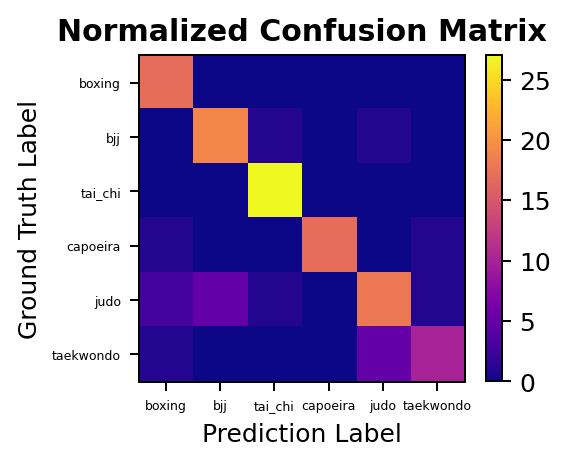

In [ ]:
%cd /content/mmaction2

from mmaction.core import (mean_class_accuracy, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt

print(mean_class_accuracy(outputs, gt_labels))
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
#print(cf_mat)


per_label_sums = cf_mat.sum(axis=1)[:, np.newaxis]
confusion_matrix = \
        cf_mat.astype(np.float32) / per_label_sums * 100

num_classes = 6
color_theme='plasma'
title='Normalized Confusion Matrix'
fig, ax = plt.subplots(
        figsize=(0.5 * num_classes, 0.5 * num_classes * 0.8), dpi=180)
cmap = plt.get_cmap(color_theme)
im = ax.imshow(cf_mat, cmap=cmap)
cbar = plt.colorbar(mappable=im, ax=ax)
#cbar.ax.locator_params(nbins=5)

title_font = {'weight': 'bold', 'size': 12}
ax.set_title(title, fontdict=title_font)
label_font = {'size': 10}
plt.ylabel('Ground Truth Label', fontdict=label_font)
plt.xlabel('Prediction Label', fontdict=label_font)


#ax.grid(True, which='minor', linestyle='-')

classes = ['boxing', 'bjj', 'tai_chi', 'capoeira', 'judo', 'taekwondo']
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes, size = 5)
ax.set_yticklabels(classes, size = 5)

Plot loss function:

In [ ]:
!python tools/analysis/analyze_logs.py plot_curve ../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json --keys loss_cls --legend loss_cls --out ../drive/MyDrive/Martial_Arts/models/PoseC3D/loss_graph.pdf

plot curve of ../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json, metric is loss_cls
save curve to: ../drive/MyDrive/Martial_Arts/models/PoseC3D/loss_graph.pdf


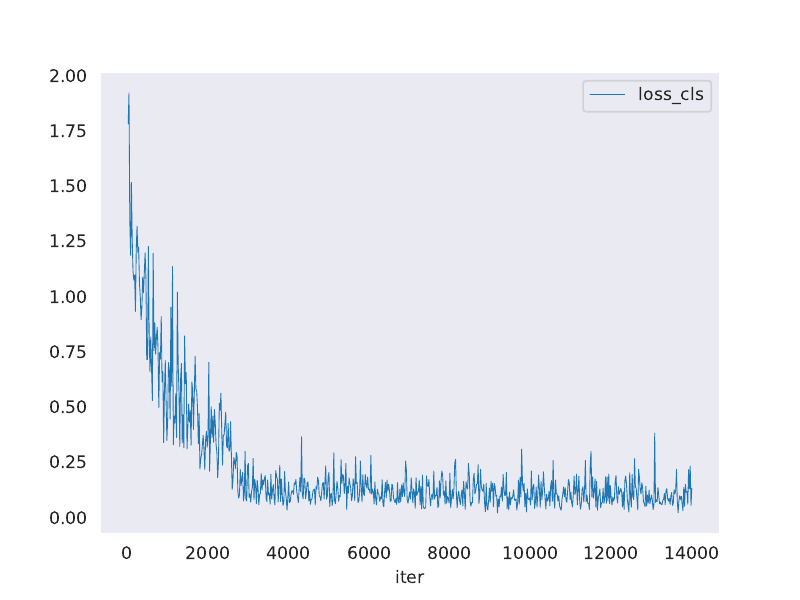

In [ ]:
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import display, Image

images = convert_from_bytes(open('../drive/MyDrive/Martial_Arts/models/PoseC3D/loss_graph.pdf', 'rb').read(), size=800)
display(images[0])

In [ ]:
!python tools/analysis/analyze_logs.py plot_curve ../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json --keys top1_acc top5_acc --out ../drive/MyDrive/Martial_Arts/models/PoseC3D/1vs5_graph.pdf

plot curve of ../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json, metric is top1_acc
plot curve of ../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json, metric is top5_acc
save curve to: ../drive/MyDrive/Martial_Arts/models/PoseC3D/1vs5_graph.pdf


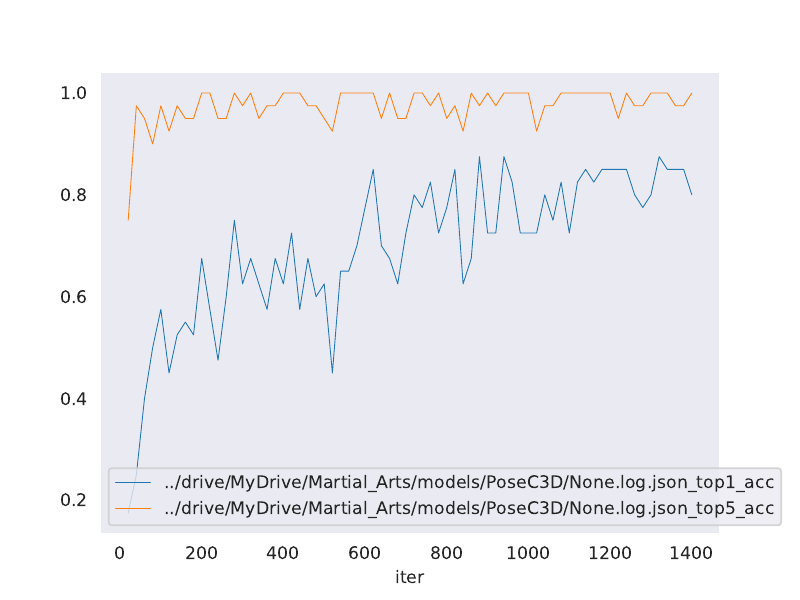

In [ ]:
images = convert_from_bytes(open('../drive/MyDrive/Martial_Arts/models/PoseC3D/1vs5_graph.pdf', 'rb').read(), size=800)
display(images[0])

In [ ]:
import json

#necessary because log.json stores multiple dicts in parallel, for a json we need a big dicts of dicts
new_log = []
for line in open('../drive/MyDrive/Martial_Arts/models/PoseC3D/None.log.json', 'r'):
    new_log.append(json.loads(line))

print(new_log[1])

### Visualization

In [ ]:
%cd /content

In [ ]:
import os
import cv2
import os.path as osp
import decord
import numpy as np
import matplotlib.pyplot as plt
import urllib
import moviepy.editor as mpy
import random as rd
from mmpose.apis import vis_pose_result
from mmpose.models import TopDown
from mmcv import load, dump

# We assume the annotation is already prepared
gym_train_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/gym_train.pkl'
gym_val_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/gym_val.pkl'
ntu60_xsub_train_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/ntu60_xsub_train.pkl'
ntu60_xsub_val_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/ntu60_xsub_val.pkl'
data1_train_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_train.pkl'
data1_val_ann_file = '/content/drive/MyDrive/Martial_Arts/skeleton_anns/pose_data1_val.pkl'

In [ ]:
FONTFACE = cv2.FONT_HERSHEY_DUPLEX
FONTSCALE = 0.6
FONTCOLOR = (255, 255, 255)
BGBLUE = (0, 119, 182)
THICKNESS = 1
LINETYPE = 1

In [ ]:
def add_label(frame, label, BGCOLOR=BGBLUE):
    threshold = 30
    def split_label(label):
        label = label.split()
        lines, cline = [], ''
        for word in label:
            if len(cline) + len(word) < threshold:
                cline = cline + ' ' + word
            else:
                lines.append(cline)
                cline = word
        if cline != '':
            lines += [cline]
        return lines
    
    if len(label) > 30:
        label = split_label(label)
    else:
        label = [label]
    label = ['Action: '] + label
    
    sizes = []
    for line in label:
        sizes.append(cv2.getTextSize(line, FONTFACE, FONTSCALE, THICKNESS)[0])
    box_width = max([x[0] for x in sizes]) + 10
    text_height = sizes[0][1]
    box_height = len(sizes) * (text_height + 6)
    
    cv2.rectangle(frame, (0, 0), (box_width, box_height), BGCOLOR, -1)
    for i, line in enumerate(label):
        location = (5, (text_height + 6) * i + text_height + 3)
        cv2.putText(frame, line, location, FONTFACE, FONTSCALE, FONTCOLOR, THICKNESS, LINETYPE)
    return frame
    

def vis_skeleton(vid_path, anno, category_name=None, ratio=0.5):
    #vid = decord.VideoReader(vid_path)
    #frames = [x.asnumpy() for x in vid]

    #Have to use same frame extracting method as in pkl annotations, so:
    vid = cv2.VideoCapture(vid_path)
    flag, frame = vid.read()
    frames = []
    while flag:
      frames.append(frame)
      flag, frame = vid.read()

    h, w, _ = frames[0].shape
    new_shape = (int(w * ratio), int(h * ratio))
    frames = [cv2.resize(f, new_shape) for f in frames]
    
    assert len(frames) == anno['total_frames']
    # The shape is N x T x K x 3
    kps = np.concatenate([anno['keypoint'], anno['keypoint_score'][..., None]], axis=-1)
    kps[..., :2] *= ratio
    # Convert to T x N x K x 3
    kps = kps.transpose([1, 0, 2, 3])
    vis_frames = []

    # we need an instance of TopDown model, so build a minimal one
    model = TopDown(backbone=dict(type='ShuffleNetV1'))

    for f, kp in zip(frames, kps):
        bbox = np.zeros([0, 4], dtype=np.float32)
        result = [dict(keypoints=k) for k in kp]
        #result2 = [dict(bbox=bbox, keypoints=k) for k in kp]
        vis_frame = vis_pose_result(model, f, result)
        
        if category_name is not None:
            vis_frame = add_label(vis_frame, category_name)
        
        vis_frames.append(vis_frame)
    return vis_frames

In [ ]:
keypoint_pipeline = [
    dict(type='PoseDecode'),
    dict(type='PoseCompact', hw_ratio=1., allow_imgpad=True),
    dict(type='Resize', scale=(-1, 64)),
    dict(type='CenterCrop', crop_size=64),
    dict(type='GeneratePoseTarget', sigma=0.6, use_score=True, with_kp=True, with_limb=False)
]

limb_pipeline = [
    dict(type='PoseDecode'),
    dict(type='PoseCompact', hw_ratio=1., allow_imgpad=True),
    dict(type='Resize', scale=(-1, 64)),
    dict(type='CenterCrop', crop_size=64),
    dict(type='GeneratePoseTarget', sigma=0.6, use_score=True, with_kp=False, with_limb=True)
]

from mmaction.datasets.pipelines import Compose
def get_pseudo_heatmap(anno, flag='keypoint'):
    assert flag in ['keypoint', 'limb']
    pipeline = Compose(keypoint_pipeline if flag == 'keypoint' else limb_pipeline)
    return pipeline(anno)['imgs']

def vis_heatmaps(heatmaps, channel=-1, ratio=8):
    # if channel is -1, draw all keypoints / limbs on the same map
    import matplotlib.cm as cm
    h, w, _ = heatmaps[0].shape
    newh, neww = int(h * ratio), int(w * ratio)
    
    if channel == -1:
        heatmaps = [np.max(x, axis=-1) for x in heatmaps]
    cmap = cm.viridis
    heatmaps = [(cmap(x)[..., :3] * 255).astype(np.uint8) for x in heatmaps]
    heatmaps = [cv2.resize(x, (neww, newh)) for x in heatmaps]
    return heatmaps

In [ ]:
# Load data1 annotations
data1_categories = ['boxing', 'bjj', 'tai_chi', 'capoeira', 'judo', 'taekwondo']
data1_annos = load(data1_train_ann_file) #+ load(data1_val_ann_file)

In [ ]:
data1_root = '/content/drive/MyDrive/Martial_Arts/data1/train'
data1_vids = os.listdir(data1_root)

In [ ]:
# visualize pose of which video?
idx = 8
vid = data1_vids[idx]

vid = creative_commons_vids[12]
# creative_commons_vids[5] for clear boxing but with unwanted people or annotations behind, '_tMrLgMEP2s_7.mp4'

frame_dir = vid.split('.')[0]
vid_path = osp.join(data1_root, vid)
anno = [x for x in data1_annos if x['frame_dir'] == frame_dir][0]

In [ ]:
# Visualize Skeleton
vis_frames = vis_skeleton(vid_path, anno, data1_categories[anno['label']])
vid = mpy.ImageSequenceClip(vis_frames, fps=24)
vid.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
keypoint_heatmap = get_pseudo_heatmap(anno)
keypoint_mapvis = vis_heatmaps(keypoint_heatmap)
keypoint_mapvis = [add_label(f, data1_categories[anno['label']]) for f in keypoint_mapvis]
vid = mpy.ImageSequenceClip(keypoint_mapvis, fps=24)
vid.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
limb_heatmap = get_pseudo_heatmap(anno, 'limb')
limb_mapvis = vis_heatmaps(limb_heatmap)
limb_mapvis = [add_label(f, data1_categories[anno['label']]) for f in limb_mapvis]
vid = mpy.ImageSequenceClip(limb_mapvis, fps=24)
vid.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
